In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import FE_DAE as fe
from FE_DAEsolver import *
from data_generator import *
import importlib
import cv2

In [2]:
importlib.reload(fe)

<module 'FE_DAE' from '/home/shazoop/form-and-motion/EE219A/FE_DAE.py'>

In [3]:
torch.cuda.set_device(1) #use GPU 1

In [4]:
import torchvision
import torchvision.datasets as datasets
#Download MNIST
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)

#Load
#mnist_trainset = datasets.MNIST(root='./data', train=True, download=False, transform=None)

In [5]:
torch.set_default_tensor_type('torch.cuda.FloatTensor')
torch.cuda.set_device(0) #use GPU 1

In [6]:
data_load = torch.utils.data.DataLoader(mnist_trainset, shuffle = True)

In [7]:
mov_len = 3

In [8]:
images = data_load.dataset.data[0:1000].numpy()
M = rand_trans(images, 1, 3)
data_mov = torch.from_numpy(image_gen(images,M, mov_len)).float().cuda()
data_mov = data_mov/255

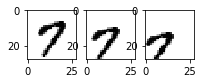

In [9]:
ix = 15
fig = plt.figure(figsize = (mov_len,5))
for i in range(mov_len):
    fig.add_subplot(1,mov_len,i+1)
    plt.imshow(data_mov[ix,i,:,:].cpu().numpy(),cmap='Greys')
plt.savefig('MNIST sequence')

In [10]:
importlib.reload(fe)

<module 'FE_DAE' from '/home/shazoop/form-and-motion/EE219A/FE_DAE.py'>

In [20]:
main = fe.FE_V1()
main.summary()

['Layer 1 has 25 units per layer, depth 16, and RF size: 12 by 12',
 'Layer 2 has 9 units per layer, depth 16, and RF size: 3 by 3',
 'Layer 3 has 4 units per layer, depth 32, and RF size: 2 by 2',
 'Time step: 0.05 s']

In [21]:
main.print_parms()

{'pixel dim': 28,
 'RF 1 dim': 12,
 'layer1 depth': 16,
 'RF 2 dim': 3,
 'layer 2 depth': 16,
 'RF 3 dim': 2,
 'layer 3 depth': 32,
 'L1Hebb': 1e-06,
 'L1AntiH': 0.01,
 'L1thresh': 1e-06,
 'L2Hebb': 2e-06,
 'L3Hebb': 3e-06,
 'L1prob': 0.125,
 'L1 stride': 4,
 'L2 stride': 1,
 'L3 stride': 1,
 'time step': 0.05}

In [1462]:
x = main.x_init()
y,W_y,Q,t,z,W_z,z_bar,v,W_v,v_bar = x

In [1463]:
trainSteps = 2000
for train in range(trainSteps):
    input_mov = data_mov[int(np.random.randint(0,data_mov.size(0),1))] #select a random movie sequence
    x = FE_movie(main,input_mov, 5, W_y = W_y, Q = Q, t = t, W_z = W_z,W_v = W_v)
    y,W_y,Q,t,z,W_z,z_bar,v,W_v,v_bar = x
    if train % 100 == 0:
        print('Step: %s' % train)
    else:
        print('Step: %s' % train, end = '\r')

Step: 0
Step: 100
Step: 200
Step: 300
Step: 400
Step: 500
Step: 600
Step: 700
Step: 800
Step: 900
Step: 1000
Step: 1100
Step: 1200
Step: 1300
Step: 1400
Step: 1500
Step: 1600
Step: 1700
Step: 1800
Step: 1900


In [1394]:
x_final = x
yF,W_yF,QF,tF,zF,W_zF,z_barF,vF,W_vF,v_barF = x_final


In [ ]:
#plot all rf, in 4X4 blocks.
fig = plt.figure(figsize = (40,40))
for j in range(5):
    for k in range(5):
        for i in range(16):
            fig.add_subplot(20,20,4*j + 80*k + 20*int(i/4) + i%4 +1)
            plt.imshow((W_yF[j,k,i,:].cpu().numpy()).reshape(12,12),cmap='Greys')
plt.savefig('MNIST_Wy')

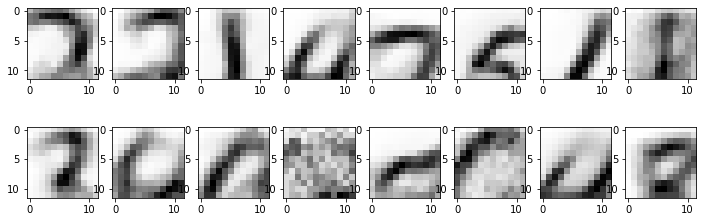

In [105]:
fig = plt.figure(figsize = (12,4))
for i in range(16):
    fig.add_subplot(2,8,i+1)
    plt.imshow((W_yF[1,2,i,:].cpu().numpy()).reshape(12,12),cmap='Greys')
plt.savefig('W_yVisual1')

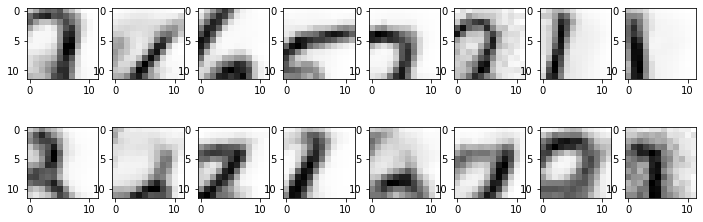

In [106]:
fig = plt.figure(figsize = (12,4))
for i in range(16):
    fig.add_subplot(2,8,i+1)
    plt.imshow((W_yF[1,3,i,:].cpu().numpy()).reshape(12,12),cmap='Greys')
plt.savefig('W_yVisual2')

In [10]:
def visZk(DAE, x, a,b,ix,k=1):
    '''Visualize higher layer weight matrices. For each "point" in the RF of a neuron, will visualize the lower layer's RF's.
    (a,b) are the Cartesian coordinates, while ix denotes the depth
    '''
    N,n1,d1,n2,d2,n3,d3, alpha, beta, gamma, eta, theta, p, S1, S2, S3, h = DAE.print_parms().values()
    L1_dim = int((N+S1-n1)/S1) #one-sided: number of units
    L2_dim = int((L1_dim + S2 - n2)/S2)
    y,W_y,Q,t,z,W_z,z_bar,v,W_v,v_bar = x
    
    fig = plt.figure(figsize = (10,10))
    WZ = W_z[a,b,ix].reshape(n2,n2,d1)
    for i in range(n2):
        for j in range(n2):
            _,idx = torch.sort(WZ[i,j,:], descending = True)
            fig.add_subplot(n2,n2,n2*i + j + 1)
            plt.imshow((1/k*W_y[(S2*a+i), (S2*b+j), idx[:k],:]).sum(dim = 0).reshape(n1,n1).cpu().numpy(), cmap = 'Greys')
            
    return 

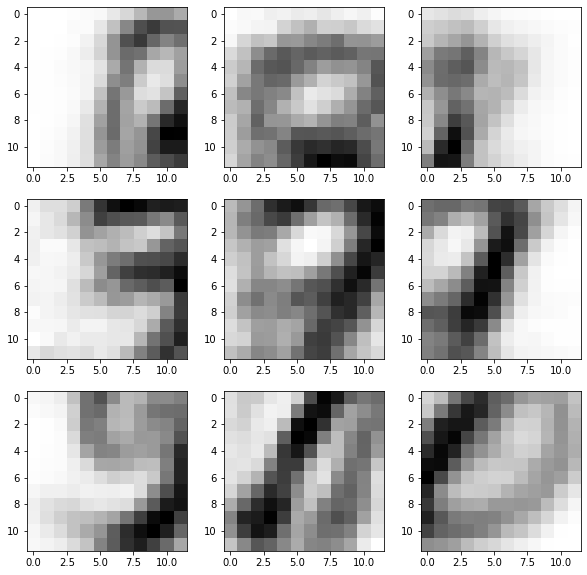

In [129]:
visZk(main, x_final2, 1,1,3,3)
plt.savefig('W_zVisualAgg2')

In [109]:
def visZ(DAE, x, a,b,ix):
    '''Visualize higher layer weight matrices. For each "point" in the RF of a neuron, will visualize the lower layer's RF's.
    (a,b) are the Cartesian coordinates, while ix denotes the depth
    '''
    N,n1,d1,n2,d2,n3,d3, alpha, beta, gamma, eta, theta, p, S1, S2, S3, h = DAE.print_parms().values()
    L1_dim = int((N+S1-n1)/S1) #one-sided: number of units
    L2_dim = int((L1_dim + S2 - n2)/S2)
    y,W_y,Q,t,z,W_z,z_bar,v,W_v,v_bar = x
    
    fig = plt.figure(figsize = (10,10))
    WZ = W_z[a,b,ix].reshape(n2,n2,d1)
    for i in range(n2):
        for j in range(n2):
            max_ix = torch.argmax(WZ[i,j,:])
            fig.add_subplot(n2,n2,n2*i + j + 1)
            plt.imshow(W_y[(S2*a+i), (S2*b+j), max_ix,:].reshape(n1,n1).cpu().numpy(), cmap = 'Greys')
            
    return 

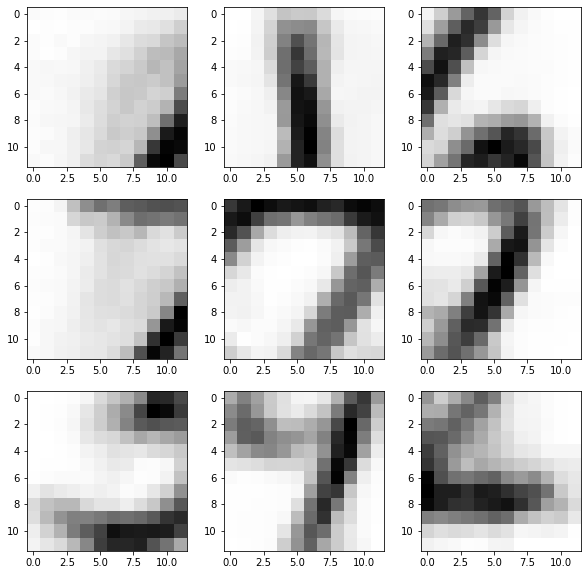

In [122]:
out = visZ(main, x_final2, 1,1,2)
plt.savefig('W_zVisual1_neighbor')